This notebook visualizes FEMNIST users. Real users and various methods of generating simulation users.

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from sklearn.manifold import TSNE
import sys

from ramsay.data.sampling import get_data_sampler

# PARENT_DIR = '/' + os.path.join(*os.getcwd().split('/')[:-1])
PARENT_DIR = os.path.dirname(os.getcwd())
sys.path.append(PARENT_DIR)

from datasets.femnist_dataset import _load_h5_into_dict
from datasets.sampler import DirichletDataSampler

In [2]:
# Helper functions

def load_femnist_as_dict():
    h5_file_path = os.path.join(PARENT_DIR, 'data', 'fed_emnist_train.h5')
    digits_only = False
    numpy_to_tensor = lambda x: x
    user_id_to_data = _load_h5_into_dict(h5_file_path, digits_only,
                                         numpy_to_tensor)
    return user_id_to_data

def get_all_labels(user_id_to_data):
    all_labels = []
    for _, y in user_id_to_data.values():
        all_labels.append(y)
    return np.hstack(all_labels)


def get_femnist_len_sampler(user_id_to_data):
    histo = np.zeros(500)
    for _, y in user_id_to_data.values():
        num_samples = len(y)
        histo[num_samples] += 1

    p = histo / sum(histo) 
    len_sampler = lambda p=p: np.random.choice(range(len(p)), p=p)
    return len_sampler

In [3]:
# Functions to generate users

def generate_true_users(user_id_to_data):
    users = []
    for _, y in user_id_to_data.values():
        labels, counts = np.unique(y, return_counts=True)
        full_y = np.zeros(62)
        full_y[labels] = counts
        users.append(full_y)
    return np.array(users)


def generate_mixture_users(num_users, alphas, phi, num_samples_dists, all_labels):
    users = []
    ks = []
    for _ in range(num_users):
        k = np.random.choice(range(len(alphas)), p=phi)
        d = num_samples_dists[k]
        n = np.random.choice(range(len(d)), p=d)

        sampler = DirichletDataSampler(alphas[k], all_labels)
        idxs = sampler(n)
        y = np.array(all_labels)[idxs]
        full_y = np.zeros(62)
        vals, count = np.unique(y, return_counts=True)
        full_y[vals] = count
        users.append(full_y)
    return np.array(users)

def generate_single_dirichlet_users(num_users, alpha, user_len_sampler, all_labels):
    sampler = DirichletDataSampler(alpha, all_labels)
    users = []
    for _ in range(num_users):
        n = user_len_sampler()
        idxs = sampler(n)
        y = np.array(all_labels)[idxs]
        full_y = np.zeros(62)
        vals, count = np.unique(y, return_counts=True)
        full_y[vals] = count
        users.append(full_y)
    return np.array(users)

def generate_uniform_users(num_users, user_len_sampler, all_labels):
    sampler = get_data_sampler('random', len(all_labels))
    users = []
    for _ in range(num_users):
        n = user_len_sampler()
        idxs = sampler(n)
        y = np.array(all_labels)[idxs]
        full_y = np.zeros(62)
        vals, count = np.unique(y, return_counts=True)
        full_y[vals] = count
        users.append(full_y)
    return np.array(users)

In [4]:
# Load femnist and get all labels
user_id_to_data = load_femnist_as_dict()
all_labels = get_all_labels(user_id_to_data)

In [5]:
# Load single dirichlet saved params
with open(os.path.join(PARENT_DIR, 'saved_mle_params', 'femnist_1_mixture.pkl'), 'rb') as f:
    params = pickle.load(f)
    
alpha_one_component =  np.array(params['alphas'][0])
num_samples_dist_one_component =  np.array(params['num_samples_dist'][0])
num_samples_dist_one_component /= sum(num_samples_dist_one_component)
len_sampler = lambda: np.random.choice(range(len(num_samples_dist_one_component)), p=num_samples_dist_one_component)

# Load two component mixture dirichlet saved params
with open(os.path.join(PARENT_DIR, 'saved_mle_params', 'femnist_2_mixture.pkl'), 'rb') as f:
    params = pickle.load(f)

phi = np.array(params['phi'])
phi /= sum(phi)
alphas =  np.array(params['alphas'])
num_samples_dists =  np.array(params['num_samples_dist'])
num_samples_dists /= num_samples_dists.sum(axis=1, keepdims=True)
print(phi.shape, alphas.shape, num_samples_dists.shape)

(2,) (2, 62) (2, 500)


In [6]:
# Generate all users, takes a few mins to run

true_users = generate_true_users(user_id_to_data)
simulated_dirichlet_mixture_users = generate_mixture_users(len(true_users), alphas, phi, num_samples_dists, all_labels)
simulated_single_dirichlet_users = generate_single_dirichlet_users(len(true_users), alpha_one_component, len_sampler, all_labels)
simulated_uniform_users = generate_uniform_users(len(true_users), len_sampler, all_labels)

In [7]:
# Run TSNE on the label counts of all users
tsne2 = TSNE(n_components=2)
X = np.vstack([true_users, simulated_single_dirichlet_users, simulated_uniform_users, simulated_dirichlet_mixture_users])
X = X / X.sum(axis=1, keepdims=True) # This will normalize the counts to proportions to ignore num sample per user effects
X_2dim = tsne2.fit_transform(X)

/Users/ainecahill/.miniconda3/envs/v310/lib/python3.10/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


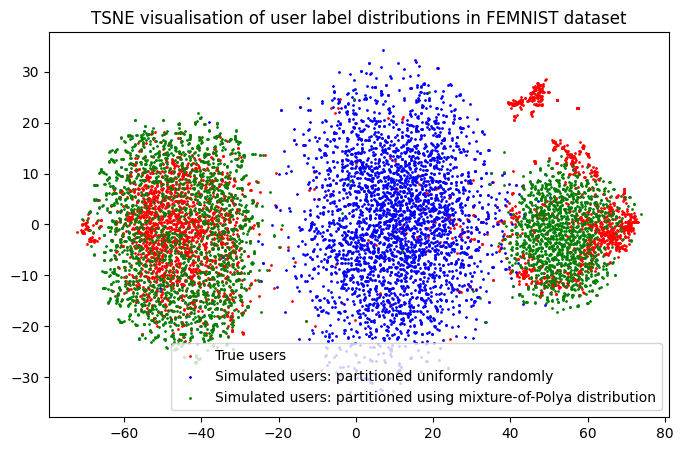

In [29]:
N = len(true_users)
plt.figure(figsize=(8, 5))
plt.title('TSNE visualisation of user label distributions in FEMNIST dataset')
plt.scatter(X_2dim[:N, 0], X_2dim[:N, 1], s=1, color='red', label='True users')
#plt.scatter(X_2dim[N:2*N, 0], X_2dim[N:2*N, 1], s=5, label='single dirichlet simulation')
plt.scatter(X_2dim[2*N:3*N, 0], X_2dim[2*N:3*N, 1], s=1, color='blue', label='Simulated users: partitioned uniformly randomly')
plt.scatter(X_2dim[3*N:, 0], X_2dim[3*N:, 1], s=1, color='green', label='Simulated users: partitioned using mixture-of-Polya distribution')
plt.legend(fontsize=10)

